<a href="https://colab.research.google.com/github/unkind58/Project_Football_Kits_Classifier/blob/main/football_kits_classifier_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Yellow & green colored football kits classifier

## Main idea and stuffing

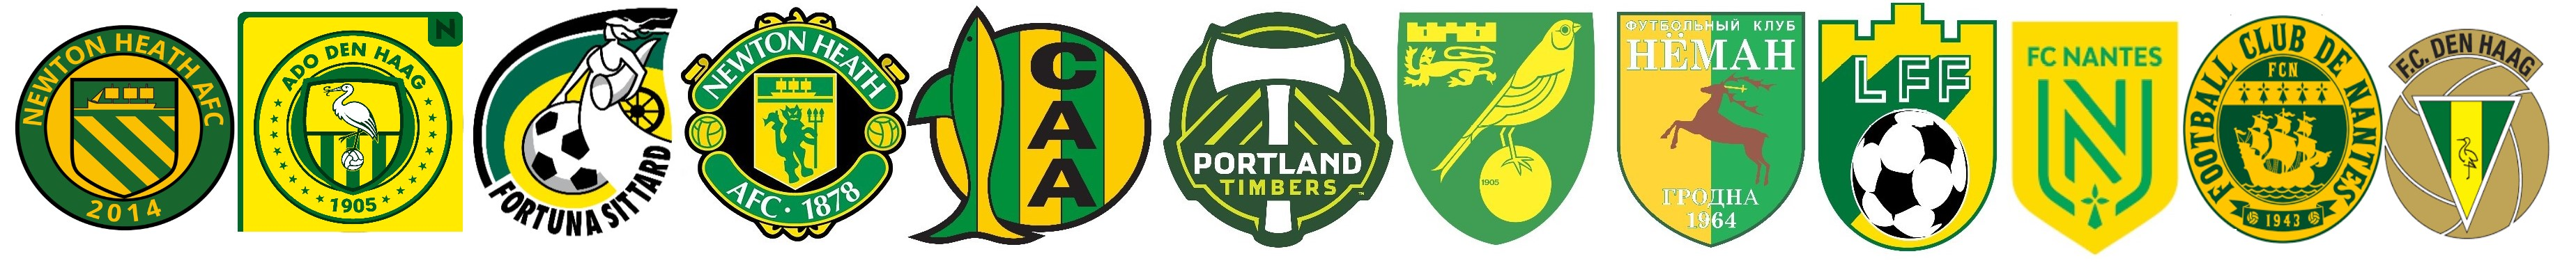

Multiclass classifier will predict from ten clubs which in different period of time have yellow & green colored football kits:

* Norwich City F.C.;
* West Bromwich Albion F.C.;
* FC Nantes;
* Club Atletico Aldosivi;
* Manchester United F.C.;
* ADO Den Haag;
* FC Neman Grodno;
* Portland Timbers;
* Sunderland A.F.C.
* Fortuna Sittard

## Libraries and dependencies

In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0"

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai import *
from fastai.vision import *

from google.colab import drive
from IPython.display import Image

Setting random seed and mounting Google Drive where all images are stored

In [ ]:
np.random.seed(seed=58)
drive.mount('/content/gdrive')

Creating paths for loading the data and saving the models weights

In [ ]:
path = Path('/content/gdrive/MyDrive/Projects/Data')
path_save = Path('/content/gdrive/MyDrive/Projects/models')

%cd /content/gdrive/MyDrive/Projects/Data

/content/gdrive/MyDrive/Projects/Data


Exploring what are the labels of each of the folder


In [ ]:
!ls

'ADO Den Haag'		  'Fortuna Sittard'	  'Sunderland AFC'
'Club Atletico Aldosivi'  'Manchester United FC'  'West Bromwich Albion FC'
'FC Nantes'		  'Norwich City FC'
'FC Neman Grodno'	  'Portland Timbers'


## Batch Size & Image Data Bunch

Setting Batch Size

In [ ]:
bs = 8

Creating Image Data Bunch with normalization, dividing train and validation sets as 80/20.

In [ ]:
dls = ImageDataBunch.from_folder(path,train=".",valid_pct=0.2,
                                  ds_tfms=get_transforms(), 
                                  seed=58,
                                  size=224, 
                                  num_workers=4, 
                                  bs=bs).normalize(imagenet_stats)

Classes amount, sets shapes and classes names.

In [ ]:
print(f'Total training set image amount: {len(dls.train_ds)}')
print(f'Total validation set image amount: {len(dls.valid_ds)}')
print(f'Total classes number: {dls.c}')
print()
dls.classes

Total training set image amount: 196
Total validation set image amount: 48
Total classes number: 10



['ADO Den Haag',
 'Club Atletico Aldosivi',
 'FC Nantes',
 'FC Neman Grodno',
 'Fortuna Sittard',
 'Manchester United FC',
 'Norwich City FC',
 'Portland Timbers',
 'Sunderland AFC',
 'West Bromwich Albion FC']

Taking a look at a Valdiation set random Data Batch.

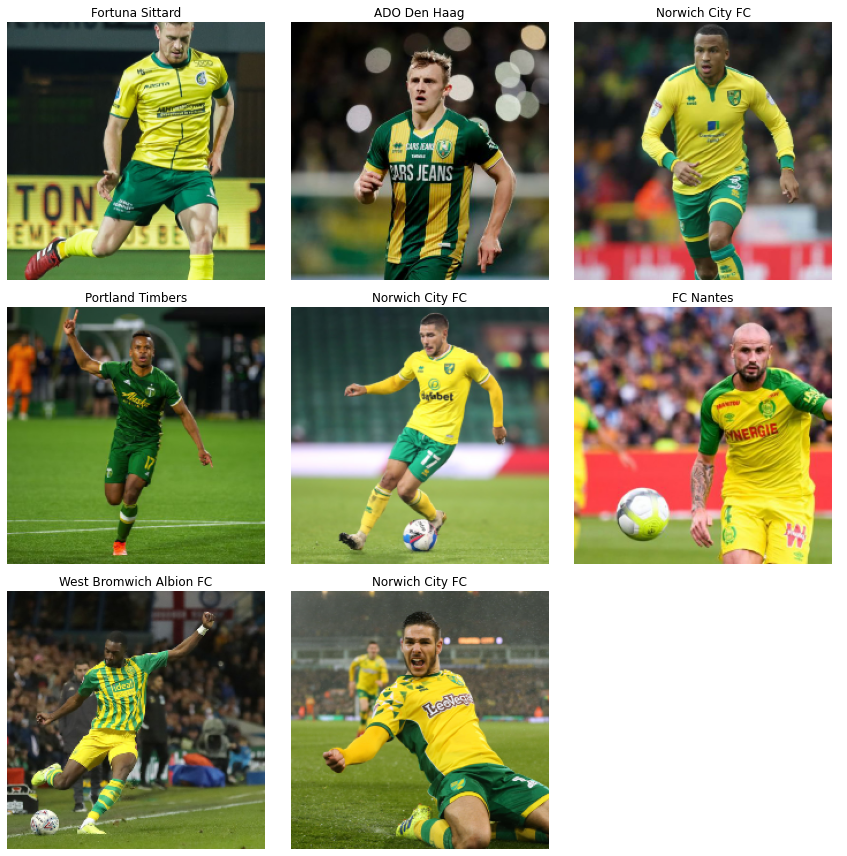

In [ ]:
dls.show_batch(ds_type=DatasetType.Valid)

## Convolutional Neural Network

### Initialization

Initializing Convolutional Neural Network  using transfer learning with RESNET34 as a pretrained model. Evaluation metric is error rate.

In [ ]:
learn = cnn_learner(dls, models.resnet34, metrics=error_rate)

Loss function - soft max.

In [ ]:
learn.loss_func

Creating a new directory for storing model's weights.


In [ ]:
learn.model_dir='/content/gdrive/MyDrive/Projects/models'
learn.path/learn.model_dir

PosixPath('/content/gdrive/MyDrive/Projects/models')

### First model fit

Running 6 epochs with .fit_one_cycle() method.

In [ ]:
learn.fit_one_cycle(6)

Ground truth VS. Predictions

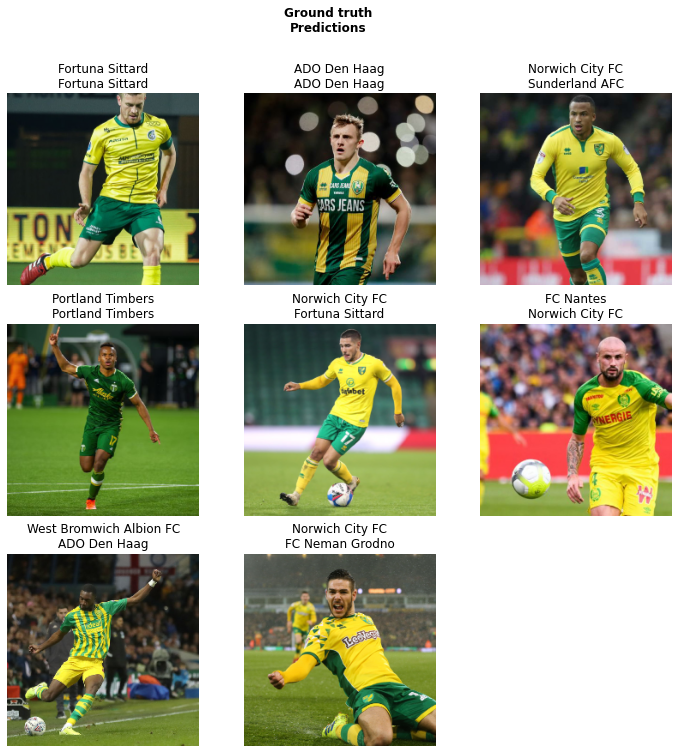

In [ ]:
learn.show_results()

Saving first stage model, unfreezing last layers and finding optimal learning rate.

In [ ]:
learn.save('stage-1')

Unfreezing all model's layers

In [ ]:
learn.unfreeze()

Computing optimal learning rate.

In [ ]:
learn.lr_find()#stop_div=False, num_it=100) #  dls.valid_ds.items

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Plotting learning rate finder's computations.

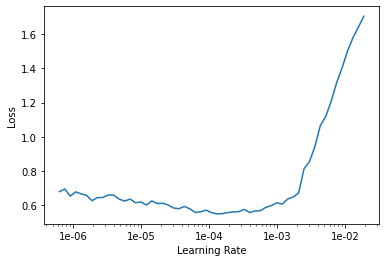

In [ ]:
learn.recorder.plot()

### Second model fit

Slicing Learning rate from 1e-4 to 3e-4.

In [ ]:
learn.fit_one_cycle(5, max_lr=slice(1e-4,3e-4))

In [ ]:
learn.save('stage-2')

### Interim interpretation of model outputs

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

Visualizing confusion matrix with all predictions.

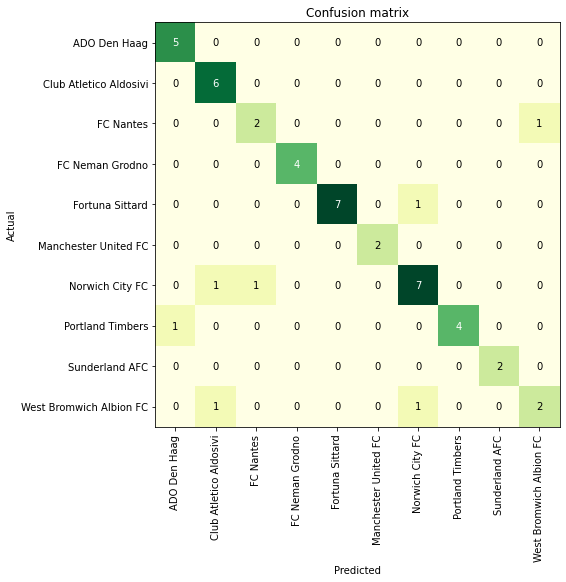

In [ ]:
interp.plot_confusion_matrix(cmap='YlGn',figsize=(12,8))

Extracting images with heatmap effect which shows me what part of the image did the CNN focus on.

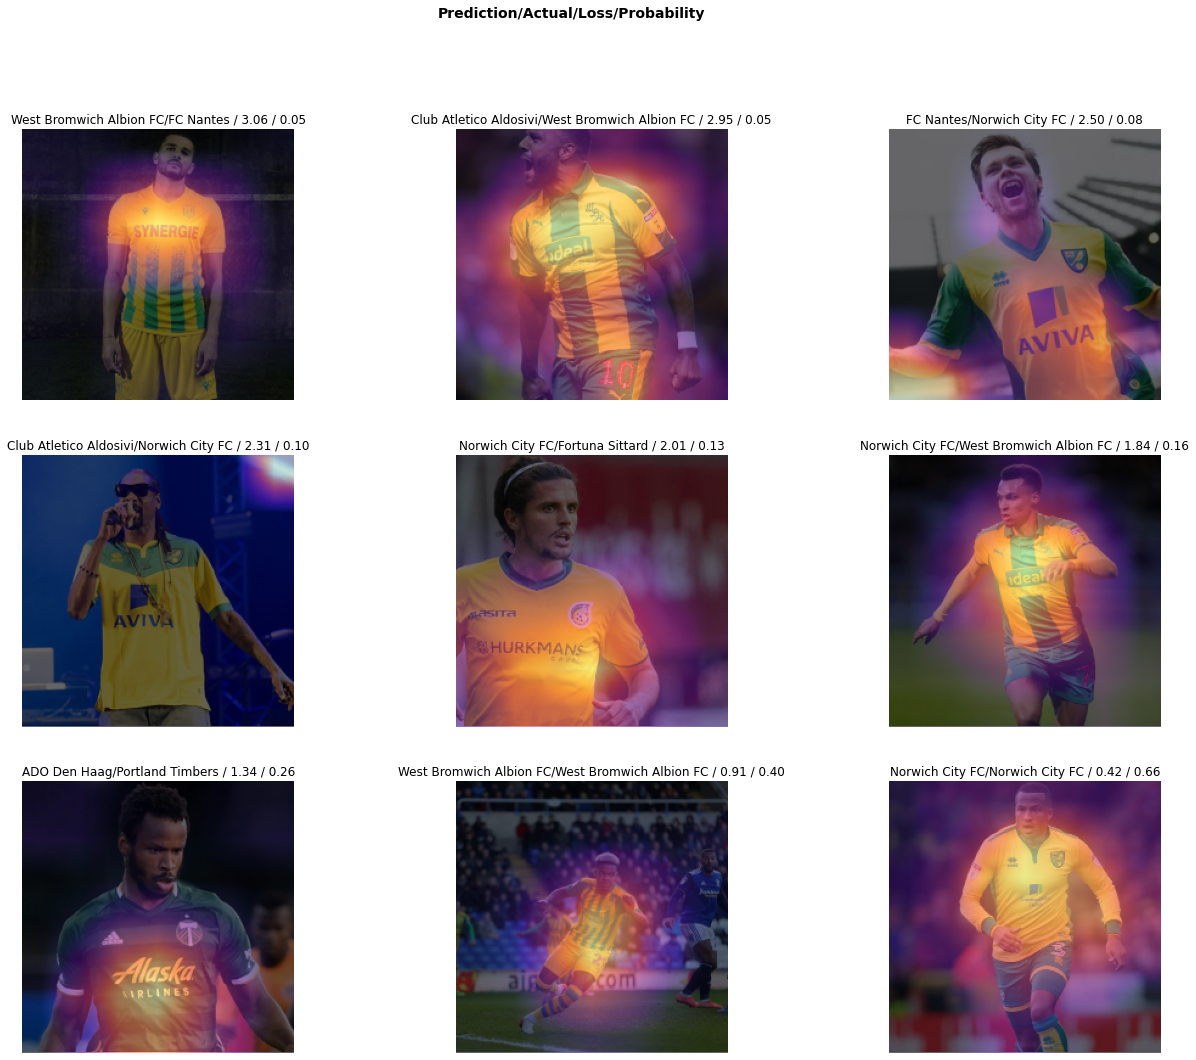

In [ ]:
interp.plot_top_losses(9, figsize=(22,17),heatmap=True)

List of recognition mistakes with threshold of minimum 1 mistake per pair.

In [ ]:
interp.most_confused(min_val=1)

[('FC Nantes', 'West Bromwich Albion FC', 1),
 ('Fortuna Sittard', 'Norwich City FC', 1),
 ('Norwich City FC', 'Club Atletico Aldosivi', 1),
 ('Norwich City FC', 'FC Nantes', 1),
 ('Portland Timbers', 'ADO Den Haag', 1),
 ('West Bromwich Albion FC', 'Club Atletico Aldosivi', 1),
 ('West Bromwich Albion FC', 'Norwich City FC', 1)]

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


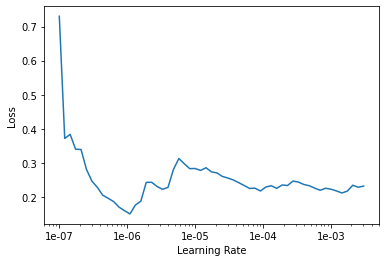

In [ ]:
learn.recorder.plot(skip_start=0, skip_end=5) 

### Third model lfit

Takinf 1-e7 learning rate

In [ ]:
learn.fit_one_cycle(5, max_lr=1e-7)

Overfitting as Validation error is high, training rather error low, so lets use weight decay

### Fourth model fit

In [ ]:
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-3), pct_start=0.8, wd=0.2) 

In [ ]:
learn.save('stage-3')

## Data augmentation

Trying  image augmentation

In [ ]:
tfms = get_transforms(do_flip=False,max_rotate=10.,max_zoom=1.3,max_lighting=0.4, 
                      max_warp=0.1, p_affine=1., p_lighting=1.,)

In [ ]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=58);src

ItemLists;

Train: ImageList (196 items)
Image (3, 2897, 1936),Image (3, 594, 401),Image (3, 612, 377),Image (3, 761, 564),Image (3, 612, 410)
Path: /content/gdrive/MyDrive/Projects/Data;

Valid: ImageList (48 items)
Image (3, 1888, 1152),Image (3, 410, 615),Image (3, 765, 1360),Image (3, 531, 800),Image (3, 691, 1024)
Path: /content/gdrive/MyDrive/Projects/Data;

Test: None

In [ ]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_folder()).transform(tfms, size=size, padding_mode=padding_mode).databunch(bs=bs).normalize(imagenet_stats)

In [ ]:
data_augm = get_data(224, bs)

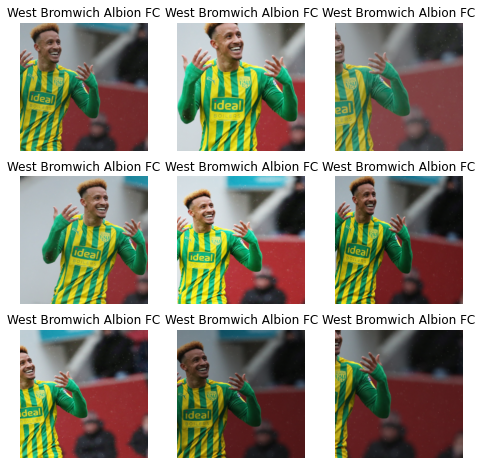

In [ ]:
def _plot(i,j,ax):
    x,y = data_augm.train_ds[58]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [ ]:
gc.collect()

17222

In [ ]:
print(f'Total training set image amount: {len(data_augm.train_ds)}')
print(f'Total validation set image amount: {len(data_augm.valid_ds)}')

Total training set image amount: 196
Total validation set image amount: 48


Changing primary data with augmented data.

In [ ]:
# learn_augm = cnn_learner(data_augm, models.resnet34, metrics=error_rate)
learn.data = data_augm

Taking a look at augmented images for training data.

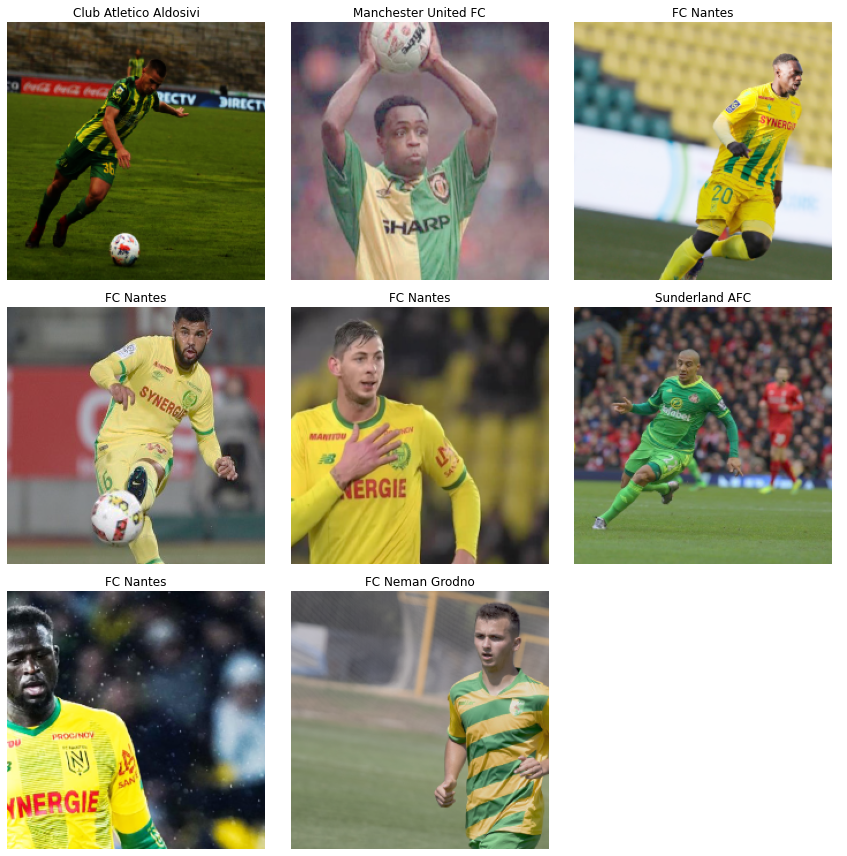

In [ ]:
data_augm.show_batch(ds_type=DatasetType.Train)

### Single model fit with augmentated images

In [ ]:
learn.fit_one_cycle(3, max_lr=slice(1e-7,1e-6), pct_start=0.8, wd=0.2)

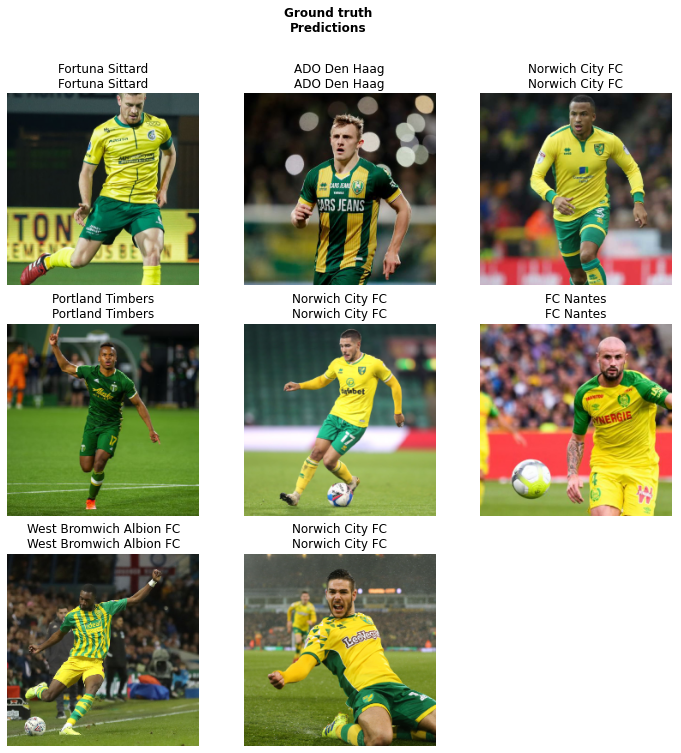

In [ ]:
learn.show_results()

In [ ]:
learn.save('stage-4')

In [ ]:
learn.lr_find(stop_div=False, num_it=158)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


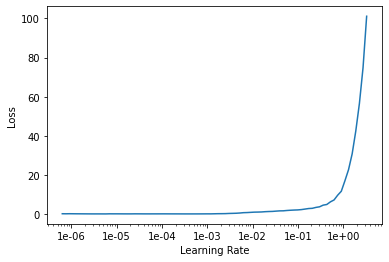

In [ ]:
learn.recorder.plot(skip_start=0, skip_end=5)

### Pre-final interpretation of model outputs

In [ ]:
interp_augm = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp_augm.most_confused(min_val=1)

[('FC Nantes', 'West Bromwich Albion FC', 1),
 ('Fortuna Sittard', 'Norwich City FC', 1),
 ('West Bromwich Albion FC', 'Club Atletico Aldosivi', 1)]

Only 3 mistakes in the end

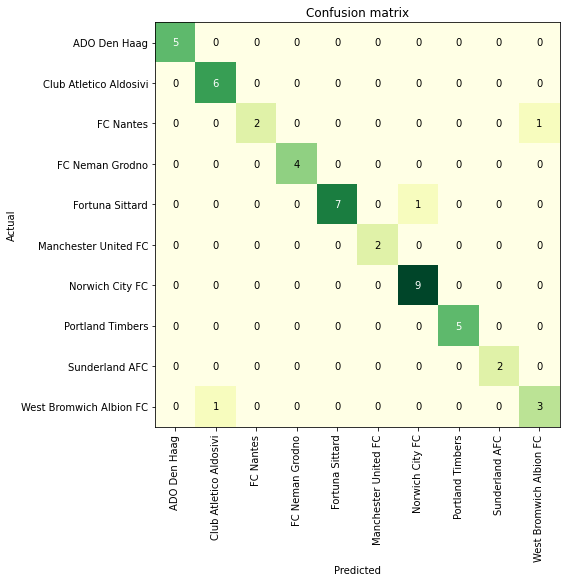

In [ ]:
interp_augm.plot_confusion_matrix(cmap='YlGn',figsize=(12,8))

# Last several fits and final error rate

Changing image size from 224 to 352

In [ ]:
data_augm2 = get_data(352,bs)
learn.data = data_augm2

In [ ]:
learn.fit_one_cycle(3, max_lr=slice(1e-2,1e-1), pct_start=0.8, wd=0.2)

Load the latest model with 0.0625 error rate, as model above went bad

In [ ]:
learn.load('stage-4') # if goes bad 

In [ ]:
learn.fit_one_cycle(3, max_lr=slice(1e-7,1e-6), pct_start=0.8, wd=0.2)

---

Error rate - 0.062500. </br>

---